**Частина 2: Аналіз часових даних**

Знайдіть набір часових даних в Інтернеті. Це може бути, наприклад, набір даних про ціни на акції, погоду, рух транспорту, або будь-які інші дані, які залежать від часу.

Завантажте та візуалізуйте ці дані. Переконайтеся, що ви розумієте основні характеристики часового ряду, такі як тренд, сезонність, аномалії тощо.

Використовуйте методи аналізу часових рядів, такі як розкладання на компоненти, автокореляція тощо, для отримання інсайтів і підготовки даних для моделювання.

Для аналізу я вирішив використати датасет з даними про ціни на акції Тесла. Планую вивести на екран для наочності ці дані у вигляді графіка. 

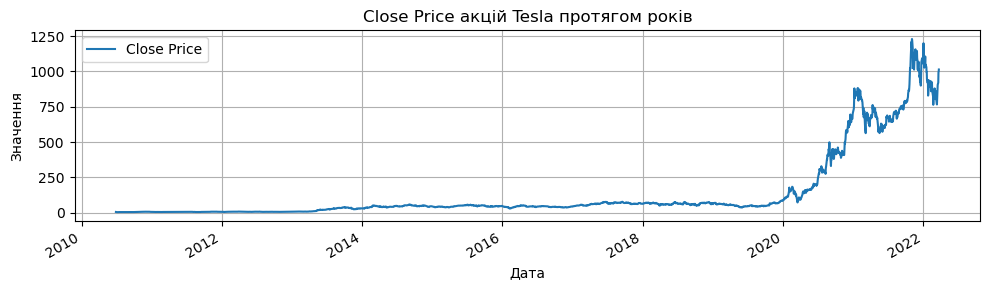

Dickey-Fuller тест:
- ADF-статистика: 1.42
- p-значення: 0.997

Критичні значення:
1%: -3.43
5%: -2.86
10%: -2.57


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,3.800000,5.000000,3.508000,4.778000,4.778000,93831500
2010-06-30,5.158000,6.084000,4.660000,4.766000,4.766000,85935500
2010-07-01,5.000000,5.184000,4.054000,4.392000,4.392000,41094000
2010-07-02,4.600000,4.620000,3.742000,3.840000,3.840000,25699000
2010-07-06,4.000000,4.000000,3.166000,3.222000,3.222000,34334500
...,...,...,...,...,...,...
2022-03-11,840.200012,843.799988,793.770020,795.349976,795.349976,22272800
2022-03-14,780.609985,800.700012,756.039978,766.369995,766.369995,23717400
2022-03-15,775.270020,805.570007,756.570007,801.890015,801.890015,22280400


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

# зчитую дані
df = pd.read_csv("TSLA.csv", parse_dates=['Date'], index_col='Date')
"""
parse_dates - колонка 'Date' розпізнається як дата
index_col - 'Date' буде як індекс в датасеті
"""
# виводжу ціну, яка мене цікавить на графік
plt.figure(figsize=(10, 3))
df['Close'].plot()
plt.ylabel("Значення")
plt.xlabel("Дата")
plt.title("Close Price акцій Tesla протягом років")
plt.legend(['Close Price'])
plt.tight_layout()
plt.grid()
plt.show()


#Дікі-Фуллер тест
result_test = adfuller(df['Close'])
print('Dickey-Fuller тест:')
print(f"- ADF-статистика: {result_test[0]:.2f}")
print(f"- p-значення: {result_test[1]:.3f}\n")

print('Критичні значення:')
for key, value in result_test[4].items():
    print(f'{key}: {value:.2f}')

    #вивід перших і останніх п'яти значень датасету
df.head(-5)

За результатами тесту Дікі-Фуллера бачимо, що даний ряд не є стаціонарним; р-значення значно більше за 0.05.



Дані у наборі за 12 років, по графіку помітно, що акції почали зростати наприкінці 2019 року. Зараз на основі цих даних я спробую дослідити тренд, виявити сезонність і тд.

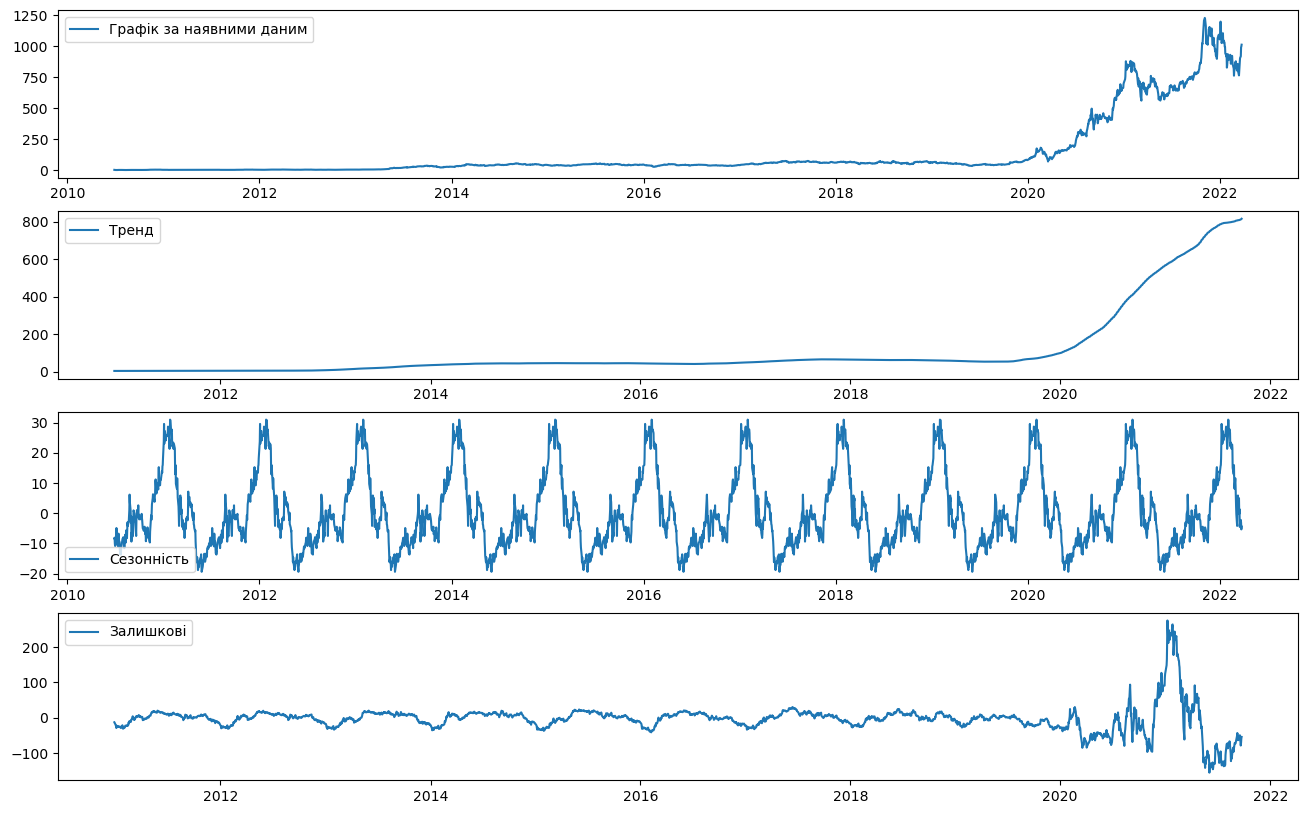

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose

# розкладання на компоненти
decomp = seasonal_decompose(df['Close'], model='additive', period=252)  # період сезонності, наприклад, 252 дні торгів на рік

#виведення графіків
plt.figure(figsize=(16, 10))
plt.subplot(4, 1, 1)
plt.plot(decomp.observed, label='Графік за наявними даним')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(decomp.trend, label='Тренд')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(decomp.seasonal, label='Сезонність')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(decomp.resid, label='Залишкові')
plt.legend()
plt.show()

Тут я досліджую обраний датасет на наявність сезонності, тренду, і залишковості. Як період сезонності я вирішив обрати 252 - приблизно стільки днів торгують на біржі в Нью-Йорку. 

По останньому графіку, залишковим даним, які не можна пояснити сезонністю/трендом, бачимо, що з 2020 року дуже багато таких даних.

Якщо подумати, то саме тоді почався ріст акцій Тесли, і з 2020 року було дуже багато різних факторів, які впливали на ріст цін, і які не можна пояснити такими категоріями як сезонність чи тренд - будівництво заводу за межами США, хороші звіти, збільшення поставок електрокарів - все це сприяло шаленому росту акцій

In [8]:
from pmdarima import auto_arima

#шукаю найкращі значення для моделі АRIMA
stepwise_fit = auto_arima(df['Close'], trace=True, suppress_warnings=True)


Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=1.22 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=24727.973, Time=0.05 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=23895.368, Time=0.08 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=23494.721, Time=0.12 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=23299.147, Time=0.30 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=23155.877, Time=0.52 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=23086.429, Time=0.48 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=1.43 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=1.17 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=23088.407, Time=0.88 sec

Best model:  ARIMA(5,2,0)(0,0,0)[0]          
Total fit time: 6.556 seconds


Далі в роботі я вирішив використовувати статистичну модель ARIMA для аналізу числових рядів та прогнозування майбутніх значень (що мене і цікавить).

Взагалі, мій датасет заскладний для цієї моделі, але, на жаль, все інше у мене ноутбук не стягує. Тому на коректні результати не розраховую.

Зверху я визначав найкращі параметри для моделі, і отримав значення - _5, 2, 0_. Також вивів графіки автокореляції і часткової автокореляції.

Знизу я виводжу графік передбачення ціни

xxx1
xxx2


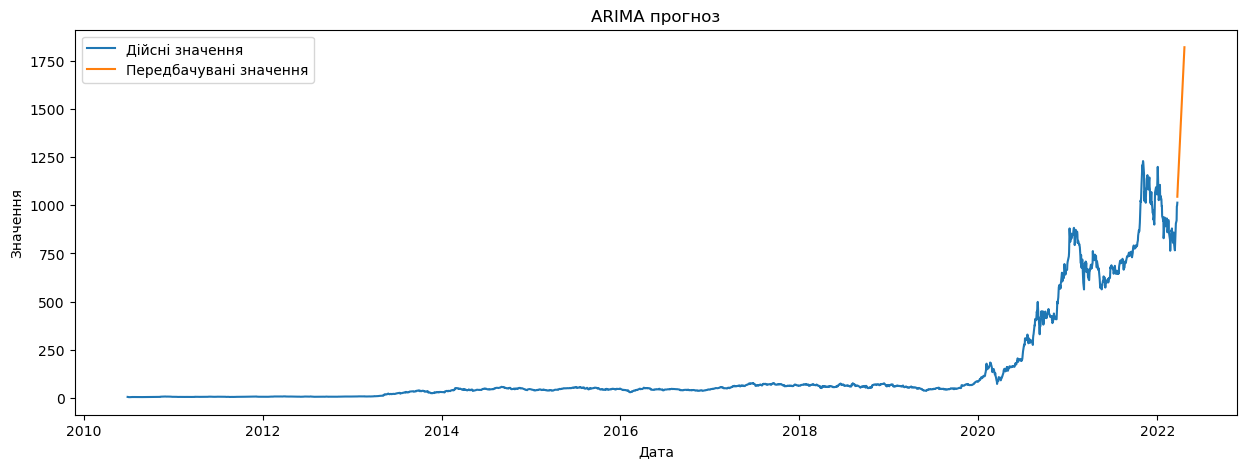

In [29]:
import statsmodels.api as sm
import warnings

#щоб не виводило зайвого
warnings.filterwarnings("ignore")

#збираємо модель із знайденими параметрами
model = sm.tsa.ARIMA(df['Close'], order=(5, 2, 0))
#тренуємо модель
results = model.fit()

#прогноз на 30 днів
forecast_steps = 30
forecasts = results.forecast(steps=forecast_steps)

#вивід графіку
plt.figure(figsize=(15, 5))
plt.plot(df['Close'], label='Дійсні значення')
plt.plot(pd.date_range(df['Close'].index[-1], periods=forecast_steps), forecasts, label='Передбачувані значення')
plt.title("ARIMA прогноз")
plt.xlabel('Дата')
plt.ylabel('Значення')
plt.legend()
plt.show()

Як бачимо, модель передбачає безперервний ріст цін на акції, оскільки попередньо також спостерігався ріст. В житті, очевидно, все працює не так. 

Так чи інакше, виконання цього завдання дозволило мені краще розібратися із аналізом даних датасетів та дозволив дізнатися про різні моделі для аналізу числових рядів.